# Question 2

This notebook investigates the pulsatility data.

In [1]:
import os

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sphincter.data_preparation import load_prepared_data

In [2]:
PLOTS_DIR = os.path.join("..", "plots")

full_data = load_prepared_data("../data/prepared/q2.json")
no_hyper_data = load_prepared_data("../data/prepared/q2-no-hyper.json")

mts, mts_full = no_hyper_data.measurements, full_data.measurements

The next cell plots the full dataset

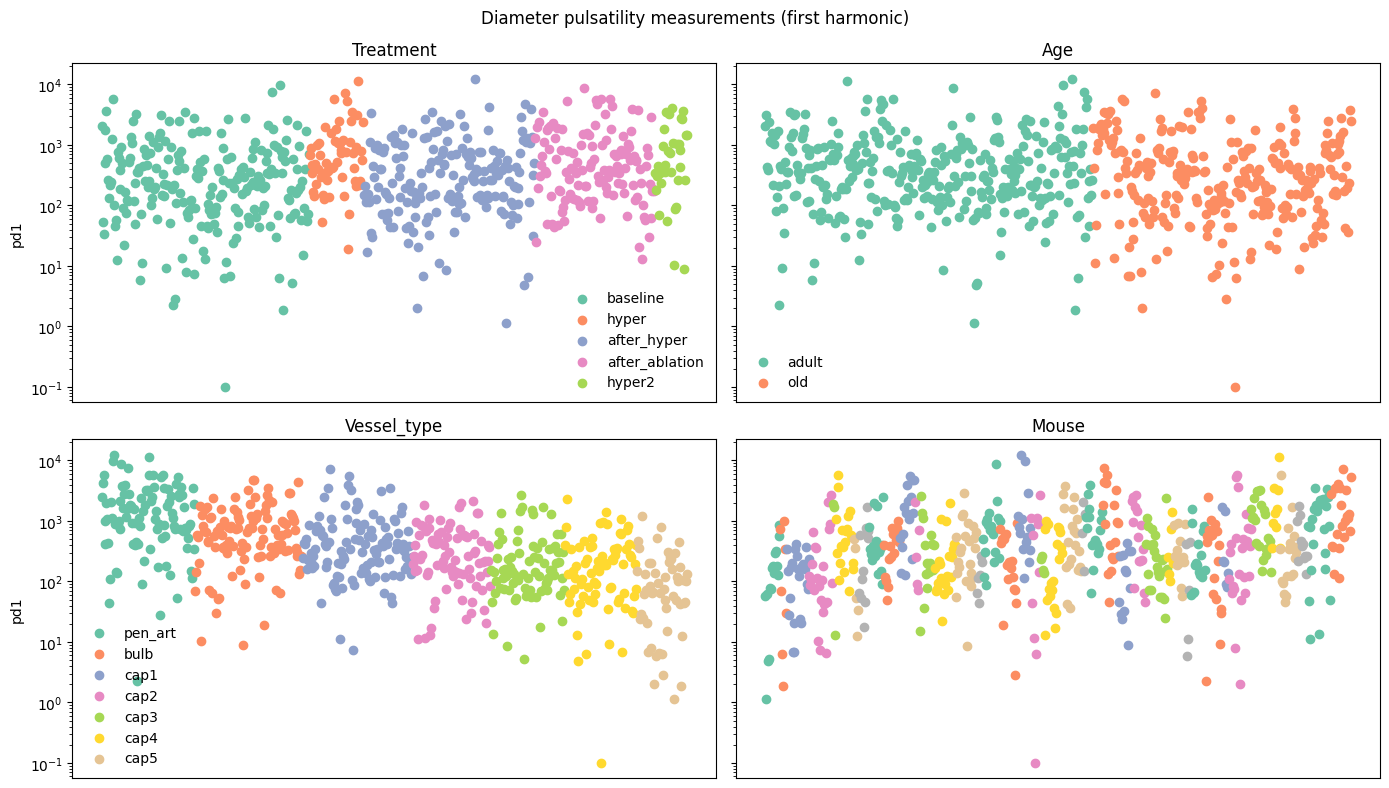

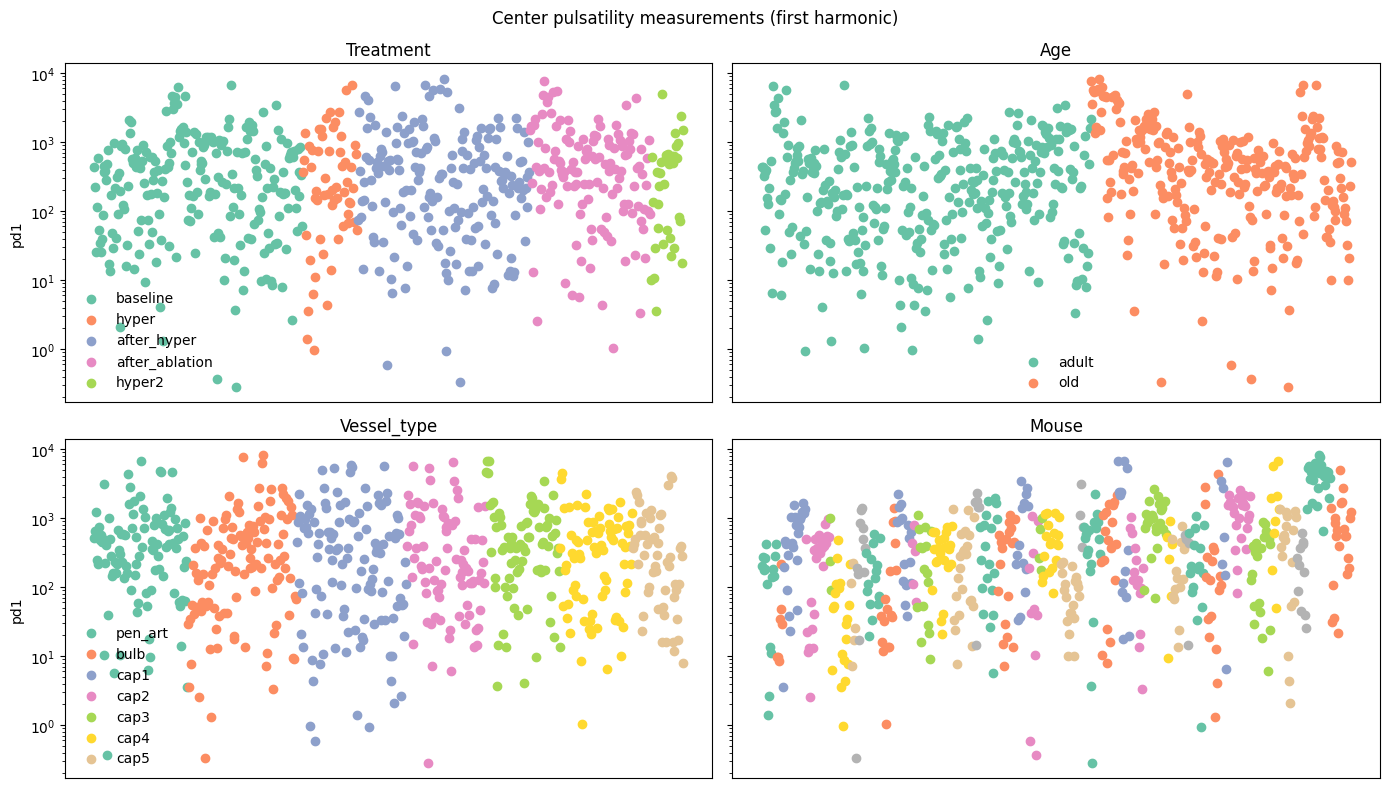

In [3]:
def plot_obs_cat(ax, obs, catcol, cmap, **scatter_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame({"obs": obs, "cat": catcol}).sort_values("cat").assign(x=np.linspace(0, 1, len(obs)))
    scts = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        color = colors[i % len(colors)]
        scts.append(ax.scatter(subdf["x"], subdf["obs"], label=cat, color=color, **scatter_kwargs))
    return scts



obs = mts_full["pd1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts_full[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()

obs = mts_full["pc1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts_full[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Center pulsatility measurements (first harmonic)");
f.tight_layout()

In order to go one step at a time I'm going to first look at the data excluding the hypertension case. 

Here's the same plot for this reduced dataset.

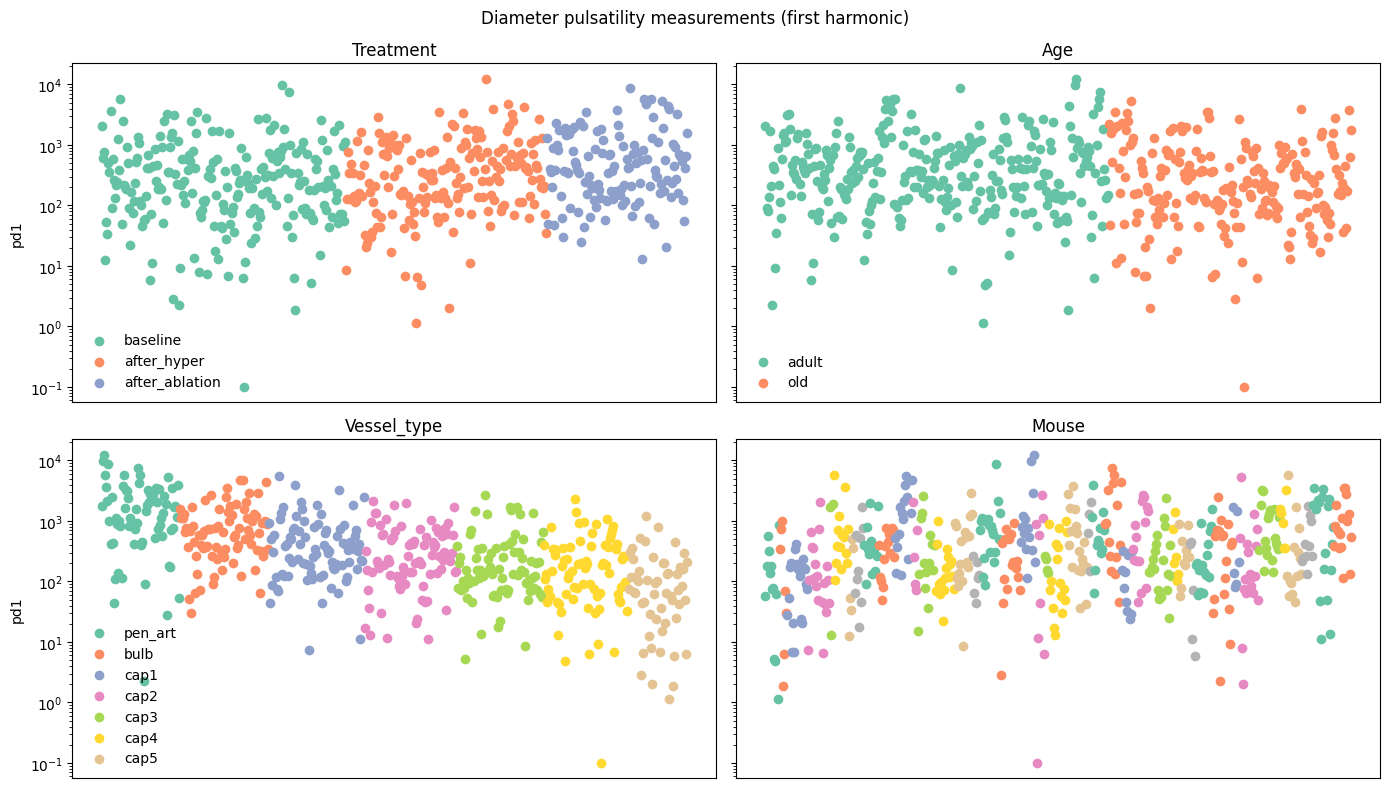

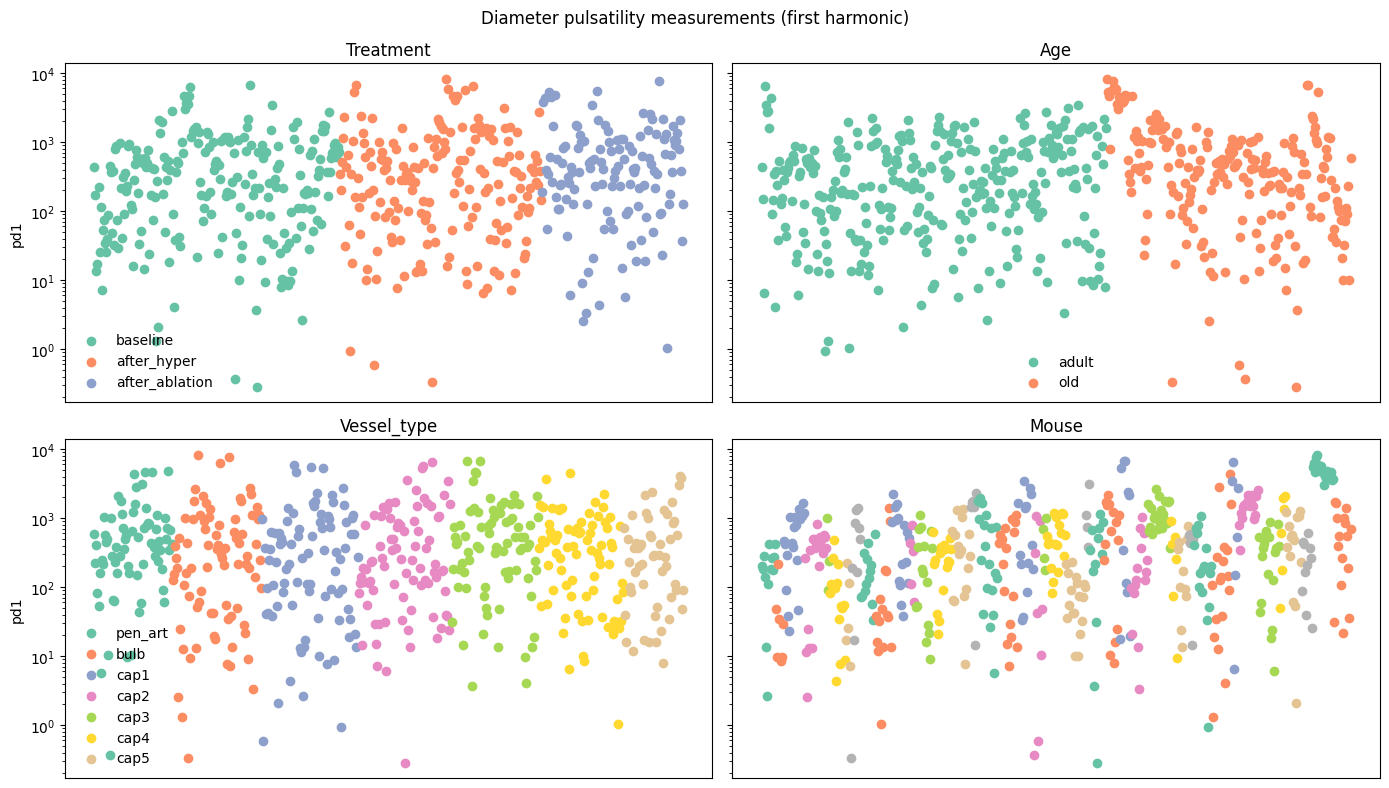

In [4]:
obs = mts["pd1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()

obs = mts["pc1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()

There is a clear pattern for the diameter power harmonics to get lower with the order of the vessel.

The treatment regime seems to make the diameter measurements closer together and somewhat higher.

The center power harmonics have an interesting cluster: one old mice seems to have had consistently high measurements.

The next cell gets that mouse's id and displays all of its center power harmonic measurements.


In [5]:
mts.loc[
    lambda df: df["mouse"] == mts.groupby("mouse", observed=True)["pc1"].max().idxmax(),
    ["age", "mouse", "vessel_type", "pd1", "pc1", "pressure_d"]
]

,age,mouse,vessel_type,pd1,pc1,pressure_d
1451,old,310321,bulb,1902.663305,7608.577584,59.531520
1443,old,310321,bulb,2181.389399,8273.689948,57.928666
1431,old,310321,bulb,3543.837687,6314.023567,59.024864
1452,old,310321,cap1,1822.053727,5434.029764,58.943973
1444,old,310321,cap1,2021.915201,5904.613560,57.896313
1432,old,310321,cap1,1601.710787,4580.553981,59.165915
1453,old,310321,cap2,47.921201,5380.567032,58.728397
1445,old,310321,cap2,11.313526,5608.649093,58.681183
1433,old,310321,cap2,412.946128,3599.470007,59.091964
1446,old,310321,cap3,156.289092,4689.428755,58.128332


There is also a blood pressure measurement for each datapoint. The next plot shows that there isn't an obvious correlation between pressure and our measurements

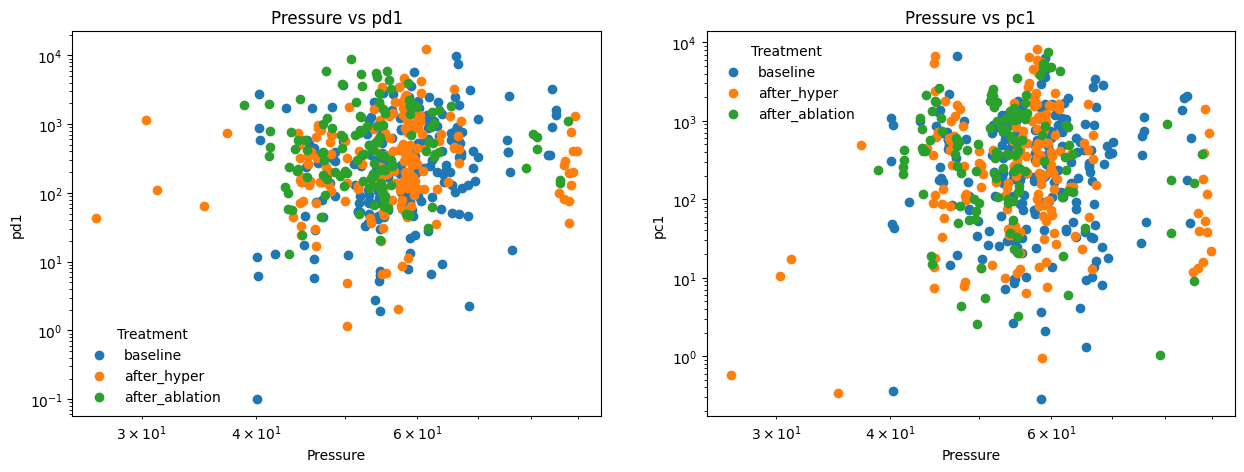

In [6]:
f, axes = plt.subplots(1, 2, figsize=[15, 5])

for ax, ycol in zip(axes, ["pd1", "pc1"]):
    for treatment, subdf in mts.groupby("treatment", observed=True):
        ax.scatter(subdf["pressure_d"], subdf[ycol], label=treatment);
    ax.legend(frameon=False, title="Treatment");
    ax.semilogy();
    ax.semilogx();
    ax.set(xlabel="Pressure", ylabel=ycol, title=f"Pressure vs {ycol}")

The first model I fit to this dataset predicts diameter and center power harmonics independently and in the same way, using the sum of four (also independent) parameters: an intercept $\mu$, an age effect $\alpha^{age}$ a treatment effect $\alpha^{treatment}$ and a vessel type effect $\alpha^{vessel\ type}$. The model creates a linear predictor out of these parameters for each measurement and fits it using an exponential GLM.

I called this model the "basic" model.

The next cell loads the results of fitting the basic model and runs a diagnostic to estimate its out of sample predictive performance. The main output metric (`elpd_loo`) is in principle absolute, representing the estimated total out of sample log likelihood under leave-one-out cross validation. However, this doesn't mean too much in isolation as it isn't clear in advance what would be a good without another model to compare with. Still, the fact that the check runs without warnings is a good sign, indicating that there weren't many very influential observations.

In [37]:
idatas = {
    "q2-basic": az.InferenceData.from_zarr(os.path.join("..", "inferences", "q2-basic", "idata"))
}
loo = {k: az.loo(v, pointwise=True) for k, v in idatas.items()}
loo["q2-basic"]

Computed from 4000 posterior samples and 533 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -652.75    50.78
p_loo       28.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      531   99.6%
 (0.5, 0.7]   (ok)          2    0.4%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The next cell plots the marginal distributions of the basic model's main parameters.

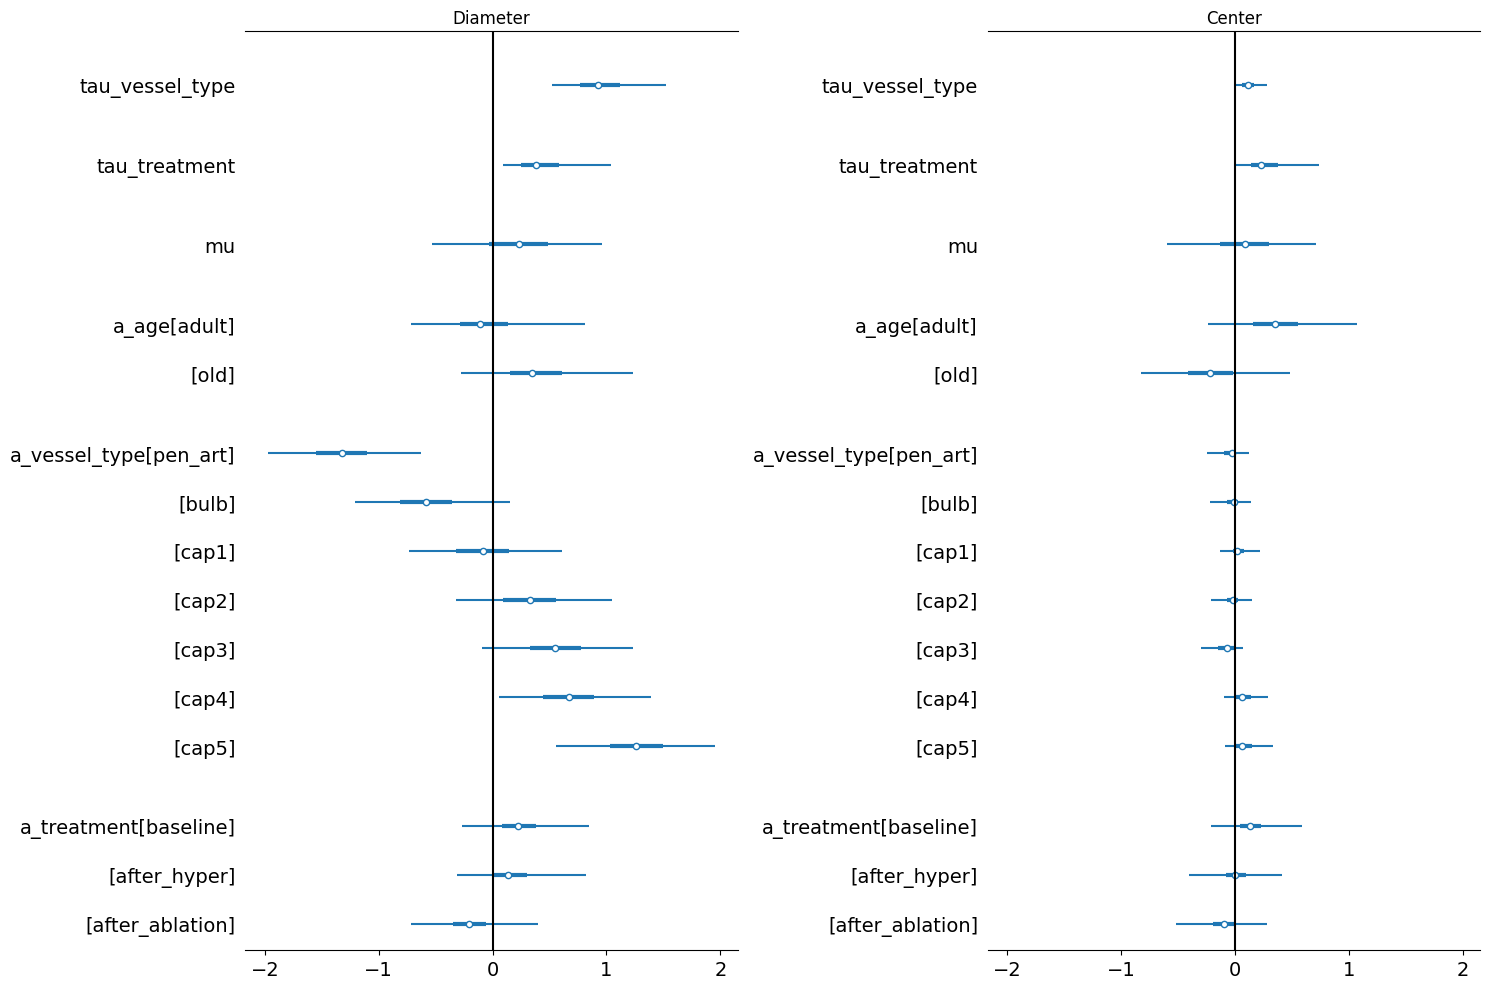

In [11]:
vars = ["tau_vessel_type", "tau_treatment", "mu", "a_age", "a_vessel_type", "a_treatment"]
f, axes = plt.subplots(1, 2, figsize=[15, 10], sharex=True)
for ax, mt in zip(axes, ["diameter", "center"]):
    az.plot_forest(idatas["q2-basic"], combined=True, ax=ax, var_names=vars, coords={"measurement_type": mt});
    ax.axvline(0, color="black")
    ax.set(title=mt.capitalize())
f.tight_layout()

The next cell does a posterior predictive check, comparing measurements simulated using the model with the actually realised observations.

This shows an overall fairly good fit, though there are quite a few extreme center measurements that the model can't capture, and it seems to underfit for some mice as a result.

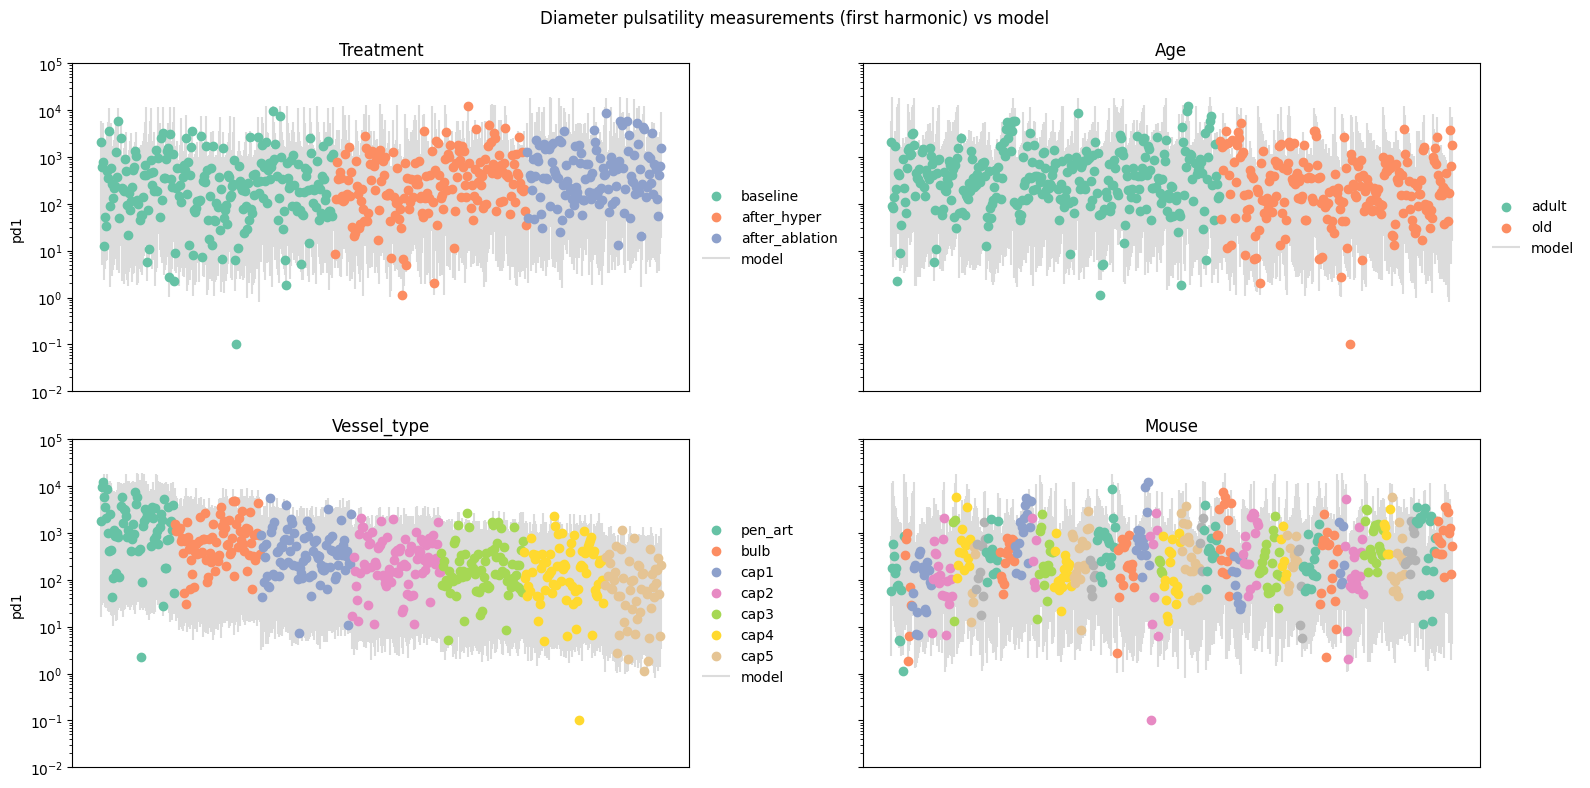

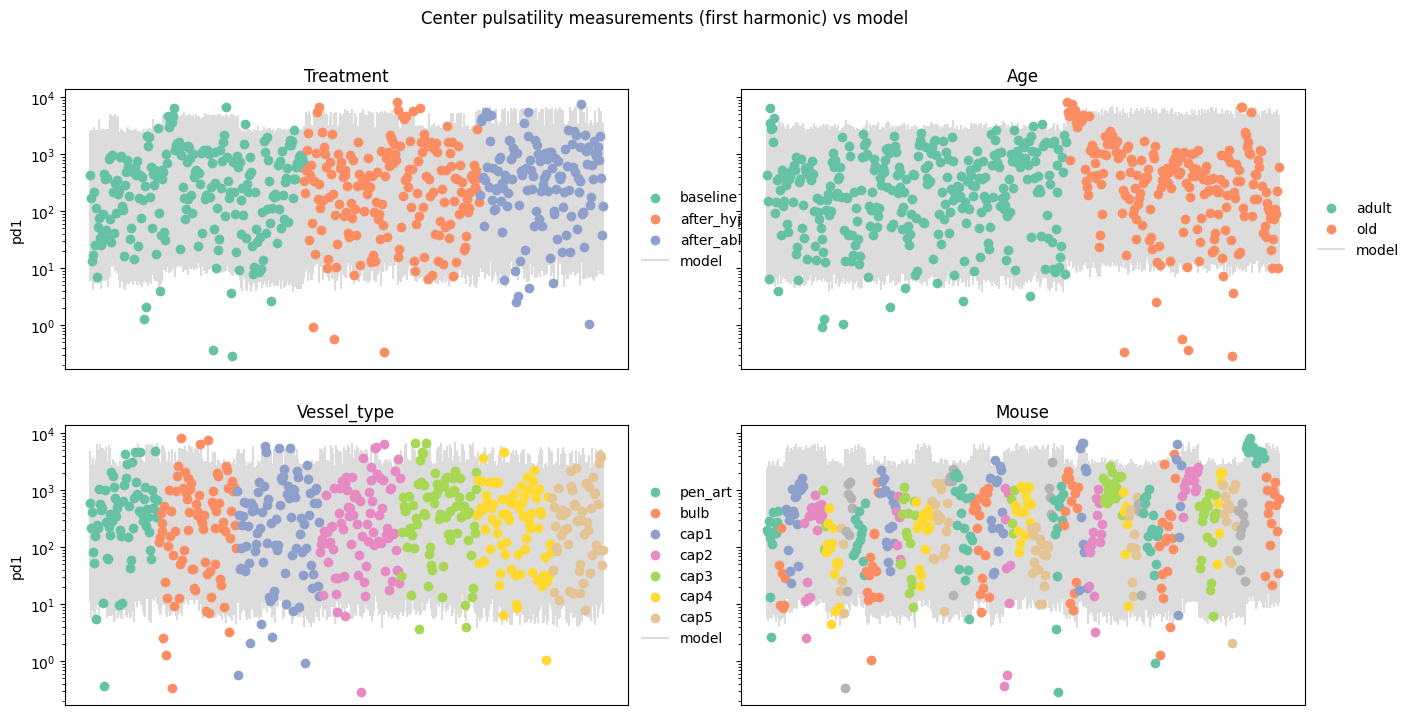

In [35]:
def plot_lines_cat(ax, yrep, catcol, cmap, **vlines_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame(
        {
            "cat": catcol,
            "q1": yrep.quantile(0.01, dim=["chain", "draw"]).values,
            "q99": yrep.quantile(0.99, dim=["chain", "draw"]).values,
        }
    ).sort_values("cat").assign(x=np.linspace(0, 1, len(catcol)))
    linesets = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        lines = ax.vlines(subdf["x"], subdf["q1"], subdf["q99"], color="gainsboro", **vlines_kwargs)
    return lines


obs = mts["pd1"]
yrep = idatas["q2-basic"].posterior_predictive["yrep"].sel(measurement_type="diameter")
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts[col].cat.remove_unused_categories()
    scts = plot_obs_cat(ax, obs, catcol, cmap)
    lines = plot_lines_cat(ax, yrep, catcol, cmap, zorder=0, label="model")
    if col != "mouse":
        ax.legend(scts + [lines], list(catcol.cat.categories) + ["model"], frameon=False, bbox_to_anchor=[1,0.5], loc="center left");
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
    ax.set_ylim(1e-2, 1e5)
f.suptitle("Diameter pulsatility measurements (first harmonic) vs model");
f.tight_layout()

obs = mts["pc1"]
yrep = idatas["q2-basic"].posterior_predictive["yrep"].sel(measurement_type="center")
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts[col].cat.remove_unused_categories()
    scts = plot_obs_cat(ax, obs, catcol, cmap)
    lines = plot_lines_cat(ax, yrep, catcol, cmap, zorder=0, label="model")
    if col != "mouse":
        ax.legend(scts + [lines], list(catcol.cat.categories) + ["model"], frameon=False, bbox_to_anchor=[1,0.5], loc="center left");
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Center pulsatility measurements (first harmonic) vs model");

The next cell plots the differences in age effects for each measurement type in the basic model. 

The plots show that, according to the basic model, diameter power harmonics tended to be higher for adult mice while center harmonics tended to be higher for old mice.

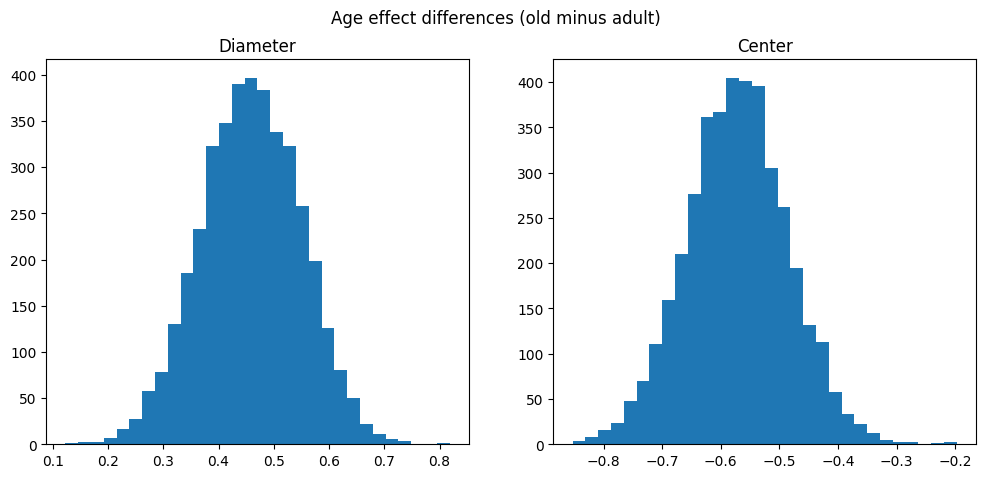

In [28]:
f, axes = plt.subplots(1, 2, figsize=[12, 5])
f.suptitle("Age effect differences (old minus adult)")
for ax, mt in zip(axes, ["diameter", "center"]):
    comp = idatas["q2-basic"].posterior["a_age"].sel(measurement_type=mt, age="old").values.flatten()
    base = idatas["q2-basic"].posterior["a_age"].sel(measurement_type=mt, age="adult").values.flatten()
    ax.hist(comp - base, bins=30)
    ax.set(title=mt.capitalize(), xlabel="")

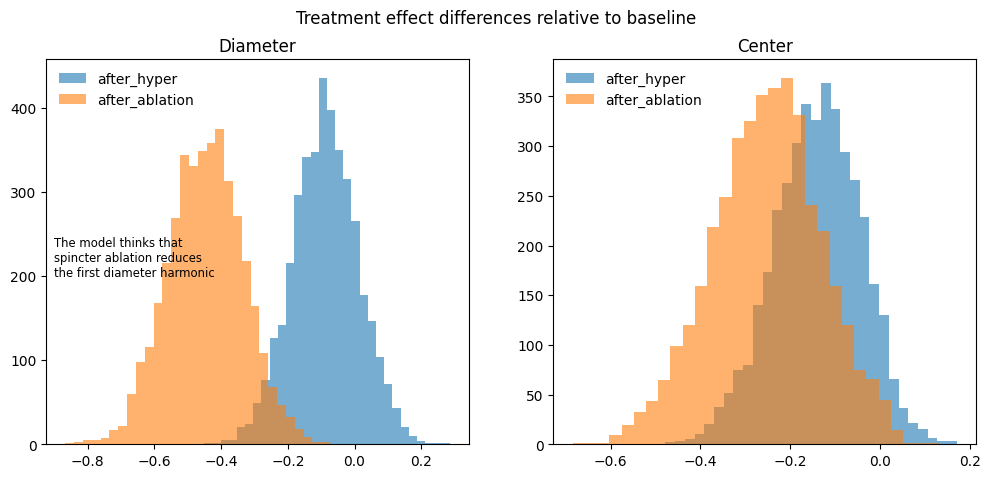

In [29]:
f, axes = plt.subplots(1, 2, figsize=[12, 5])
f.suptitle("Treatment effect differences relative to baseline")
for ax, mt in zip(axes, ["diameter", "center"]):
    for treatment in mts["treatment"].cat.remove_unused_categories().cat.categories:
        if treatment != "baseline":
            comp = idatas["q2-basic"].posterior["a_treatment"].sel(measurement_type=mt, treatment=treatment).values.flatten()
            base = idatas["q2-basic"].posterior["a_treatment"].sel(measurement_type=mt, treatment="baseline").values.flatten()
            ax.hist(comp - base, bins=30, alpha=0.6, label=treatment);
    ax.set(title=mt.capitalize(), xlabel="")
    ax.legend(frameon=False)
axes[0].text(-0.9, 200, "The model thinks that\nspincter ablation reduces\nthe first diameter harmonic", fontsize="small");